In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Food101
import torch

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
])

train_dataset = Food101(root='./data', download=False, transform=transform, split='train')
test_dataset = Food101(root='./data', download=False, transform=transform, split='test')

print(f'Train dataset original size: {len(train_dataset)}')
print(f'Test dataset original size: {len(test_dataset)}')

# sample 10% of the training dataset
train_dataset_sample = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:len(train_dataset) // 10])
test_dataset_sample = torch.utils.data.Subset(test_dataset, torch.randperm(len(test_dataset))[:len(test_dataset) // 10])

print(f'Train dataset size: {len(train_dataset_sample)}')
print(f'Test dataset size: {len(test_dataset_sample)}')

train_loader = DataLoader(train_dataset_sample, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_sample, batch_size=128, shuffle=False)

Train dataset original size: 75750
Test dataset original size: 25250
Train dataset size: 7575
Test dataset size: 2525


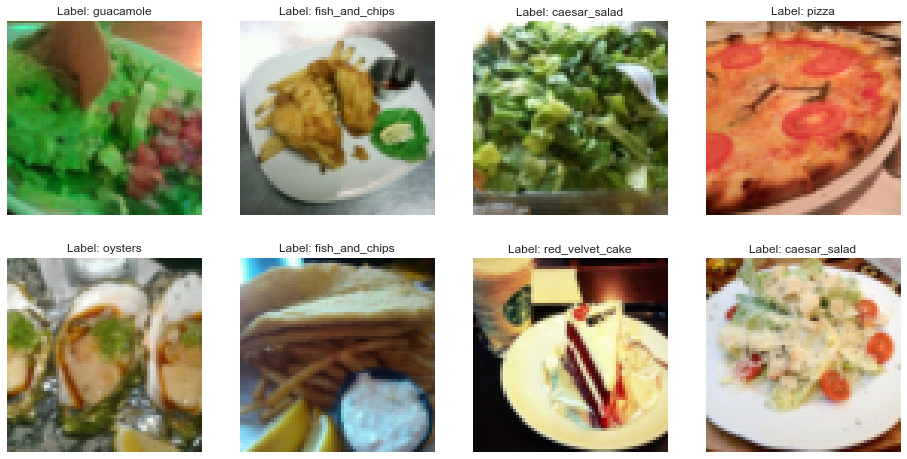

In [20]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f'Label: {train_dataset.classes[labels[i]]}')
    plt.axis('off')

## Baseline model

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16*16*10, 2560)
        self.fc2 = nn.Linear(2560, 101)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool2(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineModel().to(device)

In [52]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, accuracy_score

writer = SummaryWriter('./runs/task2_baseline')
criterion = torch.nn.NLLLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data).double() / labels.size(0)

def train_epoch(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/train', accuracy(outputs, labels), epoch * len(train_loader) + batch_idx)

def test_epoch(model, device, test_loader, epoch):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)
            pred_labels.extend(outputs.argmax(1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            writer.add_scalar('Loss/test', loss.item(), epoch * len(test_loader) + batch_idx)
            writer.add_scalar('Accuracy/test', accuracy(outputs, labels), epoch * len(test_loader) + batch_idx)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    writer.add_scalar('f1_score/test', f1, epoch)
    print(f'Average Loss: {avg_loss}\nAverage Accuracy: {avg_accuracy}\nF1 Score: {f1}')

In [53]:
epochs = 10

In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(1, epochs + 1):
    train_epoch(model, device, train_loader, optimizer, epoch)
    test_epoch(model, device, test_loader, epoch)
    print()

Average Loss: 0.03656126532224145
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.03656118487367536
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.036561105747034056
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.036561012268066406
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.036560938051431485
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.03656084664977423
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.03656075524811697
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.0365606938730372
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.03656061871217029
Average Accuracy: 0.007920792079207921
F1 Score: 0.0001244918204983563

Average Loss: 0.036560563946714496
Average A

In [55]:
writer.flush()
writer.close()

## Improved model

Now we will try to improve model by using batch normalization, dropout, and data augmentation.

Train dataset original size: 75750
Test dataset original size: 25250
Train dataset size: 7575
Test dataset size: 2525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


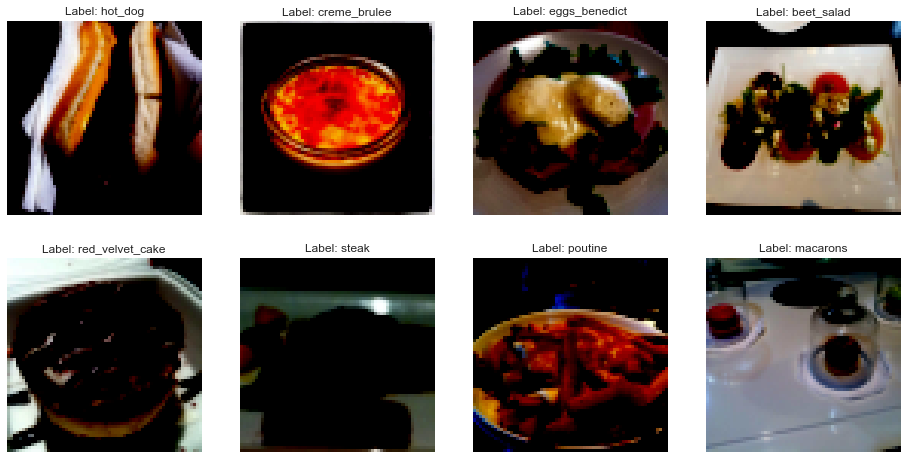

In [56]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = Food101(root='./data', download=False, transform=transform, split='train')
test_dataset = Food101(root='./data', download=False, transform=transform, split='test')

print(f'Train dataset original size: {len(train_dataset)}')
print(f'Test dataset original size: {len(test_dataset)}')

# sample 10% of the training dataset
train_dataset_sample = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:len(train_dataset) // 10])
test_dataset_sample = torch.utils.data.Subset(test_dataset, torch.randperm(len(test_dataset))[:len(test_dataset) // 10])

print(f'Train dataset size: {len(train_dataset_sample)}')
print(f'Test dataset size: {len(test_dataset_sample)}')

train_loader = DataLoader(train_dataset_sample, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_sample, batch_size=128, shuffle=False)

images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f'Label: {train_dataset.classes[labels[i]]}')
    plt.axis('off')

In [57]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(10)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(10)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(10)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc = nn.Linear(2560, 101)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = x.flatten(start_dim=1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedModel().to(device)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
writer = SummaryWriter('./runs/task2_improved')

epochs = 10
for epoch in range(1, epochs + 1):
    train_epoch(model, device, train_loader, optimizer, epoch)
    test_epoch(model, device, test_loader, epoch)
    print()

Average Loss: 0.03618032625406095
Average Accuracy: 0.023366336633663366
F1 Score: 0.01116555015892209

Average Loss: 0.03495091636582176
Average Accuracy: 0.05623762376237624
F1 Score: 0.03587221998013998

Average Loss: 0.03384089101659189
Average Accuracy: 0.06891089108910892
F1 Score: 0.052437107943265004

Average Loss: 0.03453474498031163
Average Accuracy: 0.07445544554455445
F1 Score: 0.05877312211481558

Average Loss: 0.03527783422186823
Average Accuracy: 0.06574257425742575
F1 Score: 0.057447122304065915

Average Loss: 0.03575257764004244
Average Accuracy: 0.07405940594059406
F1 Score: 0.06034877805389747

Average Loss: 0.03645783735974
Average Accuracy: 0.07762376237623762
F1 Score: 0.06430924248311845

Average Loss: 0.037597890608381514
Average Accuracy: 0.07049504950495049
F1 Score: 0.06175233873342707

Average Loss: 0.03920486790118831
Average Accuracy: 0.07287128712871287
F1 Score: 0.06484064780985954

Average Loss: 0.04149692327669351
Average Accuracy: 0.05861386138613861


In [60]:
writer.flush()
writer.close()

# DenseNet121 Transfer Learning

Train dataset original size: 75750
Test dataset original size: 25250
Train dataset size: 7575
Test dataset size: 2525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


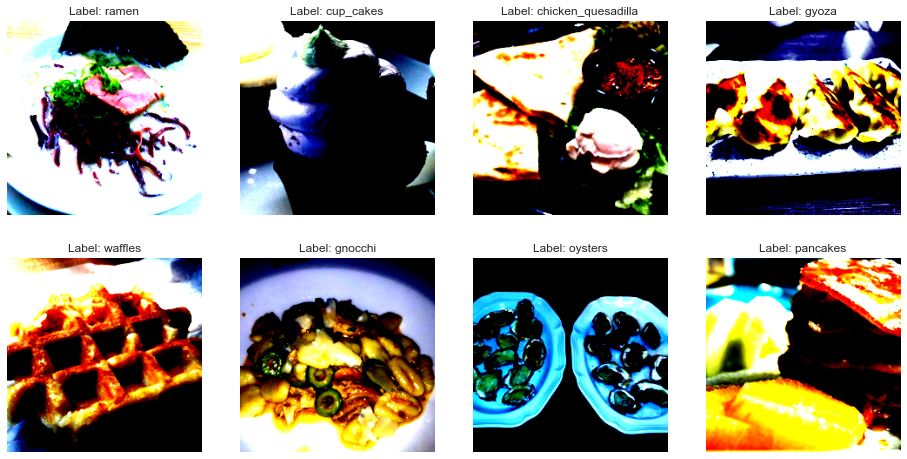

In [66]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229,0.224,0.225])
])

train_dataset = Food101(root='./data', download=False, transform=transform, split='train')
test_dataset = Food101(root='./data', download=False, transform=transform, split='test')

print(f'Train dataset original size: {len(train_dataset)}')
print(f'Test dataset original size: {len(test_dataset)}')

train_dataset_sample = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:len(train_dataset) // 10])
test_dataset_sample = torch.utils.data.Subset(test_dataset, torch.randperm(len(test_dataset))[:len(test_dataset) // 10])

print(f'Train dataset size: {len(train_dataset_sample)}')
print(f'Test dataset size: {len(test_dataset_sample)}')

train_loader = DataLoader(train_dataset_sample, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_sample, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f'Label: {train_dataset.classes[labels[i]]}')
    plt.axis('off')

In [70]:
torch.cuda.empty_cache()

In [71]:
from torchvision import models

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 101)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter('./runs/task2_transfer_learning')

epochs = 5
for epoch in range(1, epochs + 1):
    train_epoch(model, device, train_loader, optimizer, epoch)
    test_epoch(model, device, test_loader, epoch)
    print()

Average Loss: 0.046221761892337614
Average Accuracy: 0.28198019801980195
F1 Score: 0.2549855692535011

Average Loss: 0.043194252901738235
Average Accuracy: 0.36356435643564355
F1 Score: 0.35570993433380865

Average Loss: 0.03560034407247411
Average Accuracy: 0.4297029702970297
F1 Score: 0.4172088118402228

Average Loss: 0.037246388916922085
Average Accuracy: 0.4415841584158416
F1 Score: 0.43964964102812026

Average Loss: 0.030631306478292635
Average Accuracy: 0.5097029702970297
F1 Score: 0.5121265994552294



KeyboardInterrupt: 

In [73]:
writer.flush()
writer.close()

# Conclusion and possible improvements

We tried to improve baseline model by adding batch normalization and dropout layers, and also by using data augmentation. We also tried transfer learning using DenseNet121. The results are as follows: baseline model could not achieve useful results, but improved model performed a slightly better. Transfer learning model performed the best, achieving 0.51 f1 score in 5 epochs.

Possible improvements can be done by adding more data augmentations, using a more complex CNN architecture, and using multiple models and ensembling them.